In [1]:
!pip install hyperopt

In [0]:
import pandas as pd
import numpy as np

import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

from skimage import color,exposure

%load_ext tensorboard

from sklearn.metrics import accuracy_score

from hyperopt import hp,STATUS_OK,tpe,Trials,fmin


In [7]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign


In [0]:
train=pd.read_pickle('data/train.p')
test=pd.read_pickle('data/test.p')

X_train,y_train=train['features'],train['labels']
X_test,y_test=test['features'],test['labels']

In [9]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [10]:
len(np.unique(y_train))

43

In [0]:
if y_train.ndim==1: y_train=to_categorical(y_train)
if y_test.ndim==1:y_test=to_categorical(y_test)

In [0]:
input_shape=X_train.shape[1:]
num_classes=y_train.shape[1]

In [0]:
def train_model(model,X_train,y_train,params_fit={}):
  model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adam')
  
  logdir=os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback=tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

  model.fit(
      X_train,
      y_train,
      batch_size=params_fit.get('batch_size',128),
      epochs=params_fit.get('epochs',5),
      verbose=params_fit.get('verbose',1),
      validation_data=params_fit.get('validation_data',(X_train,y_train)),
      callbacks=[tensorboard_callback]    
  )

  return model

In [0]:
def predict(model_trained,X_test,y_test,scoring=accuracy_score):
  y_test_norm=np.argmax(y_test,axis=1)

  y_pred_prob=model_trained.predict(X_test)
  y_pred=np.argmax(y_pred_prob,axis=1)

  return scoring(y_test_norm,y_pred)







In [0]:
def train_and_predict(model):
  model_trained=train_model(model,X_train,y_train)
  return predict(model_trained,X_test,y_test)

In [0]:
def get_cnn_v5(input_shape,num_classes):
  return Sequential([
  Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
  Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
  Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
  Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(0.3),


  Flatten(),

  Dense(1024,activation='relu'),
  Dropout(0.3),

  Dense(1024,activation='relu'),
  Dropout(0.3),

  Dense(num_classes,activation='softmax')
])
  
#get_cnn_v4(input_shape,num_classes).summary()

#train_and_predict(get_cnn_v5(input_shape,num_classes))

In [0]:
def get_model(params):
  return Sequential([
  Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
  Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
  MaxPool2D(),
  Dropout(params['dropout_cnn_block_one']),

  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
  Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(params['dropout_cnn_block_two']),

  Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
  Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(params['dropout_cnn_block_three']),


  Flatten(),

  Dense(1024,activation='relu'),
  Dropout(params['dropout_dense_block_one']),

  Dense(1024,activation='relu'),
  Dropout(params['dropout_dense_block_two']),

  Dense(num_classes,activation='softmax')
])

In [16]:
model=get_cnn_v5(input_shape,num_classes)
model_trained=train_model(model,X_train,y_train)

predict(model_trained,X_test,y_test,scoring=accuracy_score)

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.3173 - accuracy: 0.3584 - val_loss: 0.6301 - val_accuracy: 0.8118
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 0.7077 - accuracy: 0.7772 - val_loss: 0.1647 - val_accuracy: 0.9469
Epoch 3/5
272/272 [==============================] - 4s 13ms/step - loss: 0.3809 - accuracy: 0.8833 - val_loss: 0.0890 - val_accuracy: 0.9759
Epoch 4/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2443 - accuracy: 0.9237 - val_loss: 0.0527 - val_accuracy: 0.9849
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.1969 - accuracy: 0.9421 - val_loss: 0.0309 - val_accuracy: 0.9919


0.9619047619047619

In [0]:
def func_obj(params):
  model=get_model(params)
  model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adam')
  
  model.fit(
      X_train,
      y_train,
      batch_size=int(params.get('batch_size',128)),
      epochs=5,#params.get('epochs',5),
      verbose=0,#params_fit.get('verbose',1),
        
  )
  score=model.evaluate(X_test,y_test,verbose=0)
  accuracy=score[1]
  print(params,'accuracy={}'.format(accuracy))

  return {'loss':-accuracy,'status':STATUS_OK,'model':model}

In [24]:
space={
    'batch_size':hp.quniform('batch_size',100,200,10),
    'dropout_cnn_block_one':hp.uniform('dropout_cnn_block_one',0.3,0.5),
    'dropout_cnn_block_two':hp.uniform('dropout_cnn_block_two',0.3,0.5),
    'dropout_cnn_block_three':hp.uniform('dropout_cnn_block_three',0.3,0.5),

    'dropout_dense_block_one':hp.uniform('dropout_dense_block_one',0.3,0.7),
    'dropout_dense_block_two':hp.uniform('dropout_dense_block_two',0.3,0.7)
}

best=fmin(
    func_obj,
    space,
    tpe.suggest,
    30,
    Trials()
)

{'batch_size': 100.0, 'dropout_cnn_block_one': 0.46430984035994777, 'dropout_cnn_block_three': 0.30938866046449226, 'dropout_cnn_block_two': 0.31101901998680503, 'dropout_dense_block_one': 0.5032166619424386, 'dropout_dense_block_two': 0.32047170541956843}
accuracy=0.9358276724815369
{'batch_size': 200.0, 'dropout_cnn_block_one': 0.3014662857659601, 'dropout_cnn_block_three': 0.3041591365892666, 'dropout_cnn_block_two': 0.3687877382756084, 'dropout_dense_block_one': 0.4081240436146365, 'dropout_dense_block_two': 0.5621737833010297}
accuracy=0.9575963616371155
{'batch_size': 170.0, 'dropout_cnn_block_one': 0.4910317408764835, 'dropout_cnn_block_three': 0.4926543229925436, 'dropout_cnn_block_two': 0.3132819215269599, 'dropout_dense_block_one': 0.5616130053843844, 'dropout_dense_block_two': 0.3577892473678883}
accuracy=0.8943310379981995
{'batch_size': 170.0, 'dropout_cnn_block_one': 0.45102026386313065, 'dropout_cnn_block_three': 0.4519613908954563, 'dropout_cnn_block_two': 0.33688134940

In [0]:
model=Sequential([
  Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=input_shape),

  Flatten(),
  Dense(num_classes,activation='softmax')
])

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adam')

In [0]:
def get_cnn_v1(input_shape,num_classes):
  return Sequential([
  Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=input_shape),

  Flatten(),
  Dense(num_classes,activation='softmax')
])
  




In [0]:
model=get_cnn_v1(input_shape,num_classes)
model_trained=train_model(model,X_train,y_train)

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 32.4806 - accuracy: 0.7672 - val_loss: 0.2142 - val_accuracy: 0.9479
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1813 - accuracy: 0.9576 - val_loss: 0.1100 - val_accuracy: 0.9716
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1245 - accuracy: 0.9716 - val_loss: 0.1049 - val_accuracy: 0.9766
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.0991 - accuracy: 0.9762 - val_loss: 0.0805 - val_accuracy: 0.9793
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.0759 - accuracy: 0.9814 - val_loss: 0.0536 - val_accuracy: 0.9875


In [0]:
y_pred_prob=model_trained.predict(X_test)
y_pred_prob

array([[1.8658673e-06, 1.6315496e-03, 1.7593063e-02, ..., 2.5153104e-05,
        9.4582397e-04, 2.9421056e-04],
       [3.8727529e-05, 1.9670848e-03, 1.8332794e-01, ..., 3.6638245e-05,
        4.1542926e-06, 9.6924654e-05],
       [7.6067585e-07, 1.0334024e-03, 1.8972723e-02, ..., 2.4570227e-05,
        4.1432143e-03, 6.5450813e-04],
       ...,
       [8.6624511e-03, 4.2810228e-02, 9.7290445e-03, ..., 3.9621879e-04,
        1.3878550e-03, 1.0635830e-03],
       [1.7534621e-02, 3.9192542e-02, 1.6093731e-02, ..., 7.1662280e-04,
        1.7536362e-03, 1.4878721e-03],
       [3.3121225e-03, 4.3132786e-02, 1.6106201e-02, ..., 3.5383072e-04,
        2.0224294e-03, 6.3411228e-04]], dtype=float32)

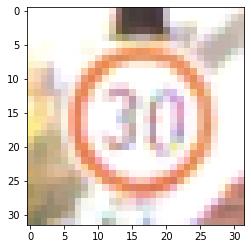

In [0]:
plt.imshow(X_test[400])

In [0]:
y_pred_prob[400]

array([2.31663436e-02, 8.95247400e-01, 7.85713254e-08, 2.07879438e-08,
       8.15848261e-02, 2.29059811e-08, 4.18738546e-16, 3.49336716e-14,
       9.60527943e-20, 1.29733428e-06, 1.18067380e-16, 2.23658864e-16,
       1.37778272e-20, 6.14496780e-15, 4.47981326e-16, 4.22334995e-17,
       2.00946930e-21, 2.71700679e-33, 3.92890439e-14, 5.24245182e-23,
       3.00768041e-19, 1.38565071e-11, 1.60270403e-31, 1.78635934e-21,
       8.94324414e-19, 1.42079725e-20, 5.95061979e-21, 1.46903195e-29,
       1.26232202e-09, 4.72304975e-13, 1.61681857e-27, 1.14429228e-15,
       1.00262145e-16, 2.23896909e-32, 2.27498965e-26, 1.81231233e-20,
       5.35660851e-30, 2.80221529e-34, 2.34472553e-27, 1.91474173e-24,
       1.57824317e-29, 7.00884609e-20, 5.56905507e-23], dtype=float32)

In [0]:
df=pd.read_csv('data/signnames.csv')
labels_dict=df.to_dict()['b']

In [0]:
labels_dict[np.argmax(y_pred_prob[400])]

'Speed limit (30km/h)'

In [0]:
np.sum(y_pred_prob[400])

1.0

ERROR! Session/line number was not unique in database. History logging moved to new session 59


<BarContainer object of 43 artists>

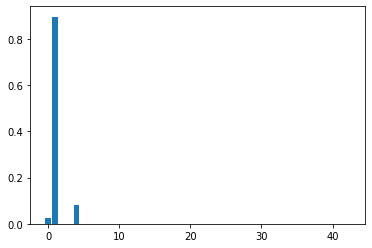

In [0]:

defplt.bar(range(43),y_pred_prob[400])

In [0]:
def get_cnn_v3(input_shape,num_classes):
  return Sequential([
  Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
  Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Flatten(),

  Dense(1024,activation='relu'),
  Dropout(0.3),

  Dense(num_classes,activation='softmax')
])
  


train_and_predict(get_cnn_v3(input_shape,num_classes))

Epoch 1/5
272/272 [==============================] - 10s 37ms/step - loss: 2.1809 - accuracy: 0.5612 - val_loss: 0.3044 - val_accuracy: 0.9339
Epoch 2/5
272/272 [==============================] - 10s 35ms/step - loss: 0.4132 - accuracy: 0.8817 - val_loss: 0.1014 - val_accuracy: 0.9755
Epoch 3/5
272/272 [==============================] - 10s 35ms/step - loss: 0.2321 - accuracy: 0.9305 - val_loss: 0.0562 - val_accuracy: 0.9872
Epoch 4/5
272/272 [==============================] - 10s 35ms/step - loss: 0.1583 - accuracy: 0.9546 - val_loss: 0.0289 - val_accuracy: 0.9931
Epoch 5/5
272/272 [==============================] - 10s 35ms/step - loss: 0.1267 - accuracy: 0.9630 - val_loss: 0.0183 - val_accuracy: 0.9961


0.9657596371882086

In [0]:
def get_cnn_v4(input_shape,num_classes):
  return Sequential([
  Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
  Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
  Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(0.3),

  Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
  Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
  MaxPool2D(),
  Dropout(0.3),


  Flatten(),

  Dense(1024,activation='relu'),
  Dropout(0.3),

  Dense(num_classes,activation='softmax')
])
  
#get_cnn_v4(input_shape,num_classes).summary()

train_and_predict(get_cnn_v4(input_shape,num_classes))

Epoch 1/5
272/272 [==============================] - 12s 45ms/step - loss: 2.6147 - accuracy: 0.2905 - val_loss: 1.2604 - val_accuracy: 0.6060
Epoch 2/5
272/272 [==============================] - 12s 42ms/step - loss: 1.0357 - accuracy: 0.6717 - val_loss: 0.3097 - val_accuracy: 0.9121
Epoch 3/5
272/272 [==============================] - 12s 42ms/step - loss: 0.4107 - accuracy: 0.8761 - val_loss: 0.1011 - val_accuracy: 0.9711
Epoch 4/5
272/272 [==============================] - 12s 42ms/step - loss: 0.2395 - accuracy: 0.9277 - val_loss: 0.0410 - val_accuracy: 0.9892
Epoch 5/5
272/272 [==============================] - 12s 43ms/step - loss: 0.1633 - accuracy: 0.9522 - val_loss: 0.0299 - val_accuracy: 0.9931


0.971655328798186

In [0]:
color.rgb2gray(X_train[0]).shape

(32, 32)

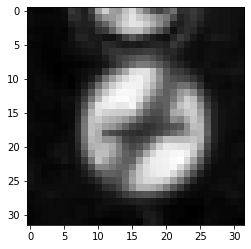

In [0]:
plt.imshow(color.rgb2gray(X_train[0]),cmap=plt.get_cmap('gray'))

In [0]:
X_train_gray=color.rgb2gray(X_train).reshape(-1,32,32,1)
X_test_gray=color.rgb2gray(X_test).reshape(-1,32,32,1)

In [0]:
model=get_cnn_v5((32,32,1),num_classes)
model_trained=train_model(model,X_train_gray,y_train,params_fit={})
predict(model_trained,X_test_gray,y_test)

Epoch 1/5
272/272 [==============================] - 12s 46ms/step - loss: 2.3706 - accuracy: 0.3267 - val_loss: 0.5844 - val_accuracy: 0.8184
Epoch 2/5
272/272 [==============================] - 12s 45ms/step - loss: 0.4925 - accuracy: 0.8429 - val_loss: 0.1139 - val_accuracy: 0.9666
Epoch 3/5
272/272 [==============================] - 12s 45ms/step - loss: 0.2183 - accuracy: 0.9310 - val_loss: 0.0498 - val_accuracy: 0.9854
Epoch 4/5
272/272 [==============================] - 12s 44ms/step - loss: 0.1454 - accuracy: 0.9549 - val_loss: 0.0319 - val_accuracy: 0.9914
Epoch 5/5
272/272 [==============================] - 12s 45ms/step - loss: 0.1102 - accuracy: 0.9662 - val_loss: 0.0191 - val_accuracy: 0.9947


0.9734693877551021

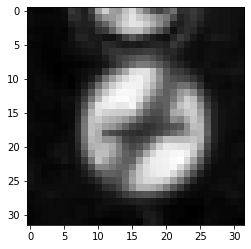

In [0]:
plt.imshow(color.rgb2gray(X_train[0]),cmap=plt.get_cmap('gray'));